In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn import preprocessing
import warnings; warnings.simplefilter('ignore')

In [229]:
# read data
train_features = pd.read_csv("train_features.csv")
train_labels = pd.read_csv("train_labels.csv")
validate_features = pd.read_csv("valid_features.csv")
validate_labels = pd.read_csv("valid_labels.csv")
test_features = pd.read_csv("test_features.csv")

In [231]:
# dealing with "labels", from categorical to numerical [0,1,2,3,4,5,6,7]
genre_class = sorted(set([v for v in train_labels["genre"].values]))
vals = sorted(set([v for v in train_labels["genre"].values]))
vals_dict = dict(zip(vals, range(len(vals))))
train_labels["genre"] = train_labels["genre"].map(lambda s: vals_dict.get(s) if s in vals_dict else s)
vals = sorted(set([v for v in validate_labels["genre"].values]))
vals_dict = dict(zip(vals, range(len(vals))))
validate_labels["genre"] = validate_labels["genre"].map(lambda s: vals_dict.get(s) if s in vals_dict else s)

{0: 1629, 1: 478, 2: 1601, 3: 303, 4: 1143, 5: 657, 6: 937, 7: 930}


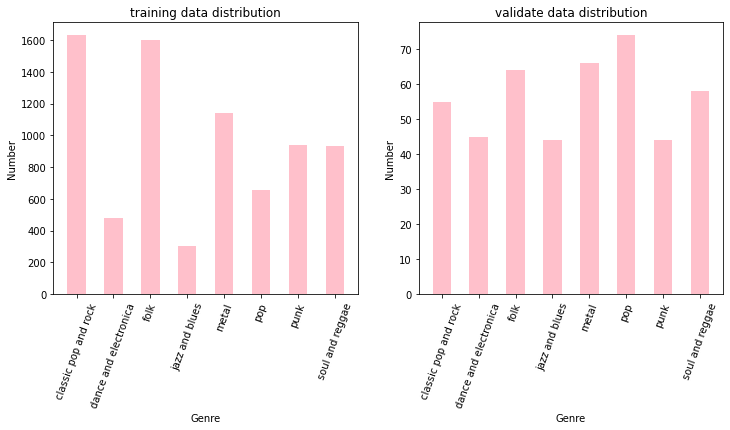

In [4]:
# check training and testing labels distribution
train_fre = {c:0 for c in sorted(set(train_labels["genre"].tolist()))}
validate_fre = {c:0 for c in sorted(set(validate_labels["genre"].tolist()))}
for i in range(len(train_labels["genre"].tolist())):
    train_fre[train_labels["genre"].tolist()[i]]+=1
for i in range(len(validate_labels["genre"].tolist())):
    validate_fre[validate_labels["genre"].tolist()[i]]+=1
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.bar(vals, list(train_fre.values()),width=0.5, color = "pink")
plt.title("training data distribution")
plt.xticks(rotation=70)
plt.xlabel("Genre")
plt.ylabel("Number")

plt.subplot(122)
plt.bar(vals, list(validate_fre.values()),width=0.5, color = "pink")
plt.title("validate data distribution")
plt.xticks(rotation=70)
plt.xlabel("Genre")
plt.ylabel("Number")
print(train_fre)

## 1. Dealing with tags features
We try to get every single tag in tags features and use Bag of words method to transfer tags features into numeric value (how many times this word appear in this instance)

Total tags:  615684
Total diff. tags:  4891


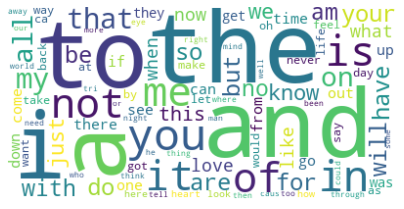

In [218]:
# check tags features and frequency
# we want to know if the most frequent word (like you, and, a, and the)effect our result
total_tags = []
for i in range(train_features.shape[0]):
    for text in train_features["tags"][i].strip().split(","):
        total_tags.append(text.strip())
total_tags_set = sorted(set(total_tags))
print("Total tags: ", len(total_tags))
print("Total diff. tags: ",len(total_tags_set))

tagsFrequency = {c: 0 for c in total_tags_set}
for i in range(train_features.shape[0]):
    for text in train_features["tags"][i].strip().split(","):
        tagsFrequency[text.strip()]+=1

tagsFrequency = {k: v for k, v in sorted(tagsFrequency.items(), key=lambda item: item[1])}
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate_from_frequencies(tagsFrequency)
plt.figure(figsize = (7,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('tagsFrequncy.png', bbox_inches = 'tight')
plt.show()

In [6]:
# slice dictionary to specific size
def sliceDictionary(dic, m = 0, n = 500):
    sliceDic = {}
    for i in range(m,n):
        sliceDic[list(dic.keys())[i]] = list(dic.values())[i]
    return sliceDic

In [7]:
# transfer lyrics tags to one-hot encoding
def oneHotTransfer(data, sliceDic):
    features = list(sliceDic.keys())
    values = []
    for i in range(len(data)):
        val = [0]*len(sliceDic)
        for text in data[i].split(","):
            text = text.strip()
            if text in sliceDic.keys():
                val[list(sliceDic.keys()).index(text)] +=1
        values.append(val)
    dataFram = pd.DataFrame(values, columns = features)
    return dataFram

In [8]:
# feature selection :  split tags features based on the reverse order of frequency
tagsFrequency_all = sliceDictionary(tagsFrequency, n = 4891)
tagsFrequency_4000 = sliceDictionary(tagsFrequency, n = 4000)
tagsFrequency_3000 = sliceDictionary(tagsFrequency, n = 3000)
tagsFrequency_2000 = sliceDictionary(tagsFrequency, n = 2000)
tagsFrequency_1000 = sliceDictionary(tagsFrequency, n = 1000)
tagsFrequency_500 = sliceDictionary(tagsFrequency, n = 500)
tags_features_train_all = oneHotTransfer(train_features["tags"], tagsFrequency_all)
tags_features_validate_all = oneHotTransfer(validate_features["tags"], tagsFrequency_all)
tags_features_train_4000 = oneHotTransfer(train_features["tags"], tagsFrequency_4000)
tags_features_validate_4000 = oneHotTransfer(validate_features["tags"], tagsFrequency_4000)
tags_features_train_3000 = oneHotTransfer(train_features["tags"], tagsFrequency_3000)
tags_features_validate_3000 = oneHotTransfer(validate_features["tags"], tagsFrequency_3000)
tags_features_train_2000 = oneHotTransfer(train_features["tags"], tagsFrequency_2000)
tags_features_validate_2000 = oneHotTransfer(validate_features["tags"], tagsFrequency_2000)
tags_features_train_1000 = oneHotTransfer(train_features["tags"], tagsFrequency_1000)
tags_features_validate_1000 = oneHotTransfer(validate_features["tags"], tagsFrequency_1000)
tags_features_train_500 = oneHotTransfer(train_features["tags"], tagsFrequency_500)
tags_features_validate_500 = oneHotTransfer(validate_features["tags"], tagsFrequency_500)

In [9]:
tags_features_train_list = [tags_features_train_500, tags_features_train_1000, tags_features_train_2000,
                            tags_features_train_3000,tags_features_train_4000,tags_features_train_all]
tags_features_validate_list = [tags_features_validate_500, tags_features_validate_1000, tags_features_validate_2000,
                              tags_features_validate_3000, tags_features_validate_4000, tags_features_validate_all]

In [10]:
# NB (non negative) (if input cv, return mean score, else, return NB classifier)
def NB_train(X,y, cv = 0):
    if cv != 0:
        NB = MultinomialNB()
        score = model_selection.cross_val_score(NB, X, y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        NB = MultinomialNB()
        NB.fit(X, y)
        return NB

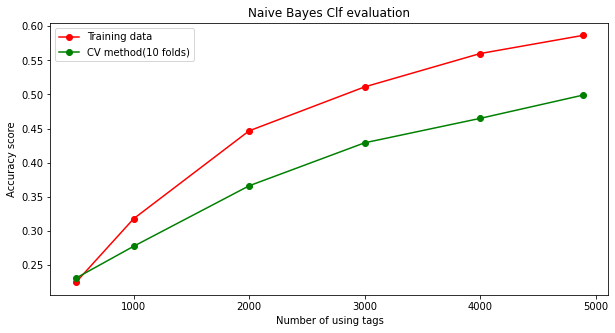

In [243]:
tagsLabel = [500, 1000, 2000, 3000, 4000, len(total_tags_set)]
scoreList = []
scoreList_cv = []
for i in range(len(tags_features_train_list)):
    clf = NB_train(tags_features_train_list[i], train_labels["genre"])
    s = NB_train(tags_features_train_list[i], train_labels["genre"], cv=10)
    scoreList.append(clf.score(tags_features_validate_list[i], validate_labels["genre"]))
    scoreList_cv.append(s)

plt.figure(figsize=(10,5))
plt.plot(tagsLabel, scoreList, "o-", color = "r", label="Training data")
plt.plot(tagsLabel, scoreList_cv, "o-", color = "g", label = "CV method(10 folds)")
plt.legend(loc="best")
plt.title("Naive Bayes Clf evaluation")
plt.xlabel("Number of using tags")
plt.ylabel("Accuracy score")
plt.show()

In [247]:
print("NB score: ",scoreList)
print("NB score for cv: ",scoreList_cv)

NB score:  [0.22444444444444445, 0.31777777777777777, 0.44666666666666666, 0.5111111111111111, 0.56, 0.5866666666666667]
NB score for cv:  [0.23065922425032595, 0.27741691791612344, 0.36610661804650146, 0.429147143904824, 0.46496360278139937, 0.4990861649826163]


In [18]:
# Logistic Regression
def LR_train(X,y, cv=0):
    LR = LogisticRegression()
    if cv != 0:
        score = model_selection.cross_val_score(LR, X, y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        LR.fit(X,y)
        return LR

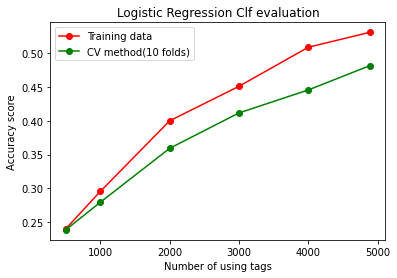

LR score:  [0.24, 0.29555555555555557, 0.4, 0.45111111111111113, 0.5088888888888888, 0.5311111111111111]
LR score with cv:  [0.2386034604519774, 0.2795004210126032, 0.35933510566058235, 0.41169464363320285, 0.44568886489569753, 0.48176489162320724]


In [248]:
tagsLabel = [500, 1000, 2000, 3000, 4000, len(total_tags_set)]
scoreList = []
scoreList_cv = []
for i in range(len(tags_features_train_list)):
    clf = LR_train(tags_features_train_list[i], train_labels["genre"])
    s = LR_train(tags_features_train_list[i], train_labels["genre"], cv=10)
    scoreList.append(clf.score(tags_features_validate_list[i], validate_labels["genre"]))
    scoreList_cv.append(s)

plt.plot(tagsLabel, scoreList, "o-", color = "r", label="Training data")
plt.plot(tagsLabel, scoreList_cv, "o-", color = "g", label = "CV method(10 folds)")
plt.legend(loc="best")
plt.title("Logistic Regression Clf evaluation")
plt.xlabel("Number of using tags")
plt.ylabel("Accuracy score")
plt.show()
print("LR score: ", scoreList)
print("LR score with cv: ", scoreList_cv)

In [21]:
# Decision Trees
def DT_train(X,y,cv=0):
    DT = DecisionTreeClassifier(criterion='entropy',max_depth=None)
    if cv!=0:
        score = model_selection.cross_val_score(DT, X, y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        DT.fit(X,y)
        return DT

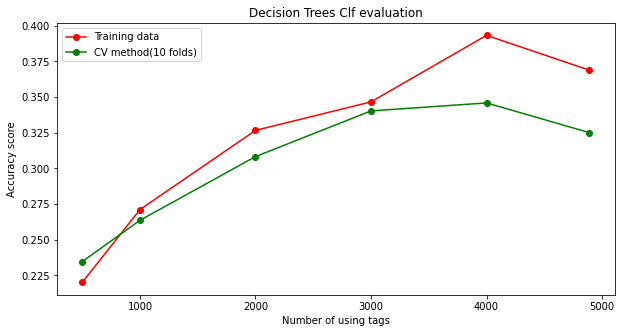

DT score:  [0.22, 0.27111111111111114, 0.32666666666666666, 0.3466666666666667, 0.3933333333333333, 0.3688888888888889]
DT score with cv:  [0.23456581377661884, 0.26360974168839635, 0.3082827439156889, 0.3403238401781834, 0.3459243263798349, 0.32508182583659273]


In [249]:
tagsLabel = [500, 1000, 2000, 3000, 4000, len(total_tags_set)]
scoreList = []
scoreList_cv = []
for i in range(len(tags_features_train_list)):
    clf = DT_train(tags_features_train_list[i], train_labels["genre"])
    s = DT_train(tags_features_train_list[i], train_labels["genre"], cv=10)
    scoreList.append(clf.score(tags_features_validate_list[i], validate_labels["genre"]))
    scoreList_cv.append(s)

plt.figure(figsize = (10,5))
plt.plot(tagsLabel, scoreList, "o-", color = "r", label="Training data")
plt.plot(tagsLabel, scoreList_cv, "o-", color = "g", label = "CV method(10 folds)")
plt.legend(loc="best")
plt.title("Decision Trees Clf evaluation")
plt.xlabel("Number of using tags")
plt.ylabel("Accuracy score")
plt.show()
print("DT score: ", scoreList)
print("DT score with cv: ", scoreList_cv)

In [23]:
# Random Forest
def RF_train(X,y, cv=0):
    RF = RandomForestClassifier()
    if cv !=0:
        score = model_selection.cross_val_score(RF, X, y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        RF.fit(X,y)
        return RF

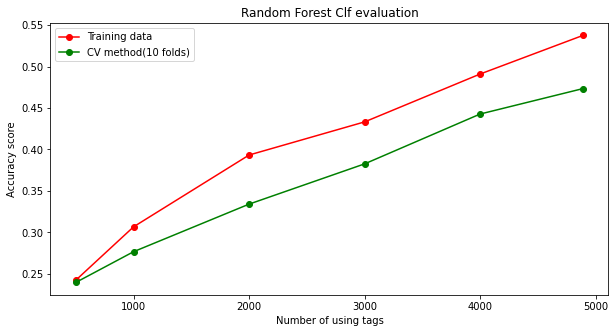

RF score:  [0.24222222222222223, 0.30666666666666664, 0.3933333333333333, 0.43333333333333335, 0.4911111111111111, 0.5377777777777778]
RF score with cv:  [0.23951457925901778, 0.27663464933724474, 0.3340678984680574, 0.3826493576162538, 0.4428183398522381, 0.4735582015971317]


In [250]:
tagsLabel = [500, 1000, 2000, 3000, 4000, len(total_tags_set)]
scoreList = []
scoreList_cv = []
for i in range(len(tags_features_train_list)):
    clf = RF_train(tags_features_train_list[i], train_labels["genre"])
    s = RF_train(tags_features_train_list[i], train_labels["genre"], cv=10)
    scoreList.append(clf.score(tags_features_validate_list[i], validate_labels["genre"]))
    scoreList_cv.append(s)

plt.figure(figsize = (10,5))
plt.plot(tagsLabel, scoreList, "o-", color = "r", label="Training data")
plt.plot(tagsLabel, scoreList_cv, "o-", color = "g", label = "CV method(10 folds)")
plt.legend(loc="best")
plt.title("Random Forest Clf evaluation")
plt.xlabel("Number of using tags")
plt.ylabel("Accuracy score")
plt.show()
print("RF score: ", scoreList)
print("RF score with cv: ", scoreList_cv)

## 2. Dealing with Metadata features
We try to compare each model based on different conditions (features selection, cross validation)

In [26]:
# split and retrieve Metadata features
meta_features_train =train_features[["loudness", "tempo", "time_signature", "key", "mode", "duration"]]
meta_features_validate =validate_features[["loudness", "tempo", "time_signature", "key", "mode", "duration"]]

In [59]:
print(meta_features_train.head(1))
print(SelectKBest(mutual_info_classif, k=5).fit_transform(meta_features_train, train_labels["genre"]))

   loudness    tempo  time_signature  key  mode   duration
0    -2.824  131.969               4    0     1  298.13506
[[ -2.824   131.969     4.        0.      298.13506]
 [-11.249   136.51      4.        4.      248.0322 ]
 [ -6.932    72.878     4.        7.      231.00036]
 ...
 [-11.883    98.596     4.       10.      255.58159]
 [ -3.518   101.639     4.        4.      547.94404]
 [ -7.217   119.586     4.        8.      226.01098]]


In [61]:
# features selection
meta_features_train_select = meta_features_train.drop(["mode"],axis=1)
meta_features_validate_select = meta_features_validate.drop(["mode"],axis=1)

In [42]:
# Gaussian NB (allow negative features, and assumption is that data follows normal distribution)
def GNB_train(X,y,cv=0):
    GNB = GaussianNB()
    if cv != 0:
        score = model_selection.cross_val_score(GNB,X,y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        GNB.fit(X,y)
        return GNB

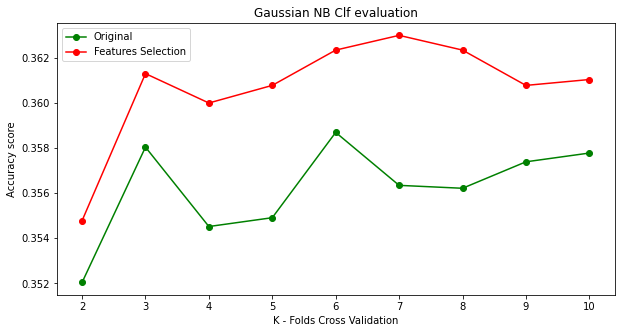

GNB score:  [0.35204480333420163, 0.3580357724371499, 0.3545208550460309, 0.35491161102062974, 0.35868853026452957, 0.3563439202374853, 0.35621429114529024, 0.35738583481362096, 0.35777413352890053]
GNB score with features selection:  [0.3547798905965095, 0.3612914895955451, 0.35999001215911064, 0.36077039223669927, 0.36233253111154545, 0.3629850535587149, 0.36233245351060134, 0.36076921880162127, 0.36102917209908736]


In [251]:
cv_list= list(range(2,11))
scoreList = []
scoreList2 = [] # features selection
for i in cv_list:
    score = GNB_train(meta_features_train, train_labels["genre"], cv=i)
    score2 = GNB_train(meta_features_train_select, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "Features Selection")
plt.title("Gaussian NB Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("GNB score: ", scoreList)
print("GNB score with features selection: ", scoreList2)

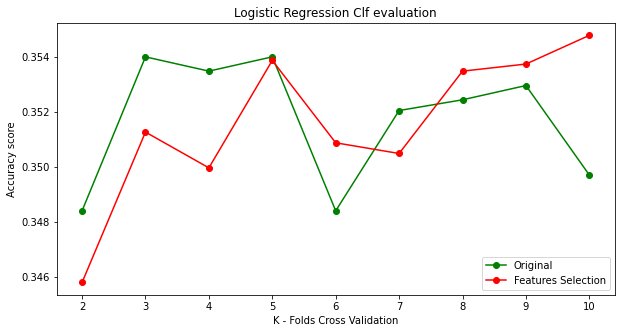

LR score:  [0.3483980203177911, 0.35399743145108764, 0.35347884911846444, 0.35399828650922904, 0.34839911959212927, 0.3520458915822182, 0.3524363486270421, 0.35295488607809633, 0.34970053780964794]
LR score with features selection:  [0.3457931753060693, 0.35126193703595154, 0.34996098499652595, 0.3538682478284474, 0.3508721616823039, 0.350483069286508, 0.35347774374348284, 0.3537361363164219, 0.3547798511516732]


In [252]:
# Logistic Regression
cv_list= list(range(2,11))
scoreList = []
scoreList2 = [] # features selection
for i in cv_list:
    score = LR_train(meta_features_train, train_labels["genre"], cv=i)
    score2 = LR_train(meta_features_train_select, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "Features Selection")
plt.title("Logistic Regression Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("LR score: ", scoreList)
print("LR score with features selection: ", scoreList2)

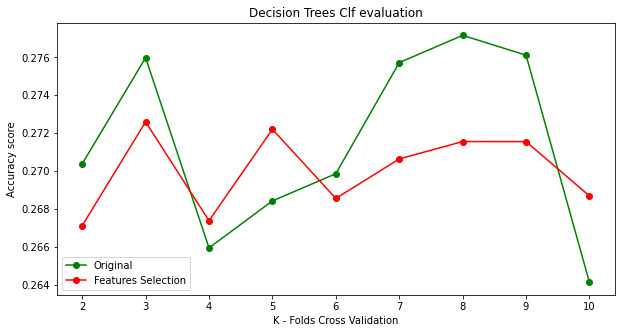

DT score:  [0.2703829122167231, 0.27598299913703267, 0.26595408307278096, 0.26843113802931595, 0.2698649661193641, 0.2757232969241167, 0.2771596389468196, 0.27611552375644394, 0.2641331214689266]
DT score with features selection:  [0.26712685595207086, 0.27259798953041553, 0.26738800319176653, 0.2722072645222584, 0.26856298459082617, 0.27064356007425694, 0.27156135948905114, 0.27155721384383963, 0.2686943176879617]


In [253]:
# Decision Trees
cv_list= list(range(2,11))
scoreList = []
scoreList2 = [] # features selection
for i in cv_list:
    score = DT_train(meta_features_train, train_labels["genre"], cv=i)
    score2 = DT_train(meta_features_train_select, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "Features Selection")
plt.title("Decision Trees Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("DT score: ", scoreList)
print("DT score with features selection: ", scoreList2)

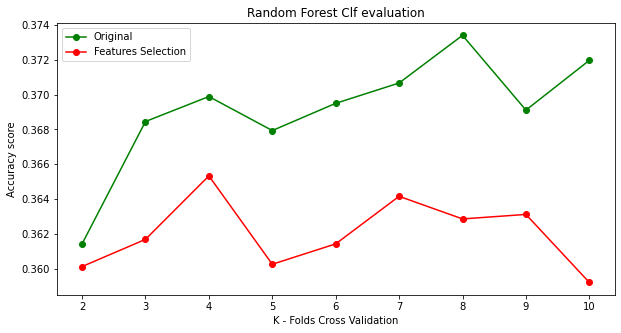

RF score:  [0.3614222453764001, 0.36845452528657024, 0.36989025588414104, 0.3679351587947882, 0.3694999959278082, 0.37066834565403983, 0.37340572862356625, 0.3691090117108221, 0.371970237125163]
RF score with features selection:  [0.36011982287053923, 0.36168226724306374, 0.3653307250955359, 0.3602519340390879, 0.36142371970289283, 0.36415636825430625, 0.3628569527719847, 0.3631155624986463, 0.3592067647218601]


In [254]:
# Random Forest
cv_list= list(range(2,11))
scoreList = []
scoreList2 = [] # features selection
for i in cv_list:
    score = RF_train(meta_features_train, train_labels["genre"], cv=i)
    score2 = RF_train(meta_features_train_select, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "Features Selection")
plt.title("Random Forest Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("RF score: ", scoreList)
print("RF score with features selection: ", scoreList2)

In [72]:
# Ensemble learning - Stacking
def Stack_train(X,y,cv=0):
    DT = DecisionTreeClassifier(criterion='entropy',max_depth=None)
    RF = RandomForestClassifier()
    GNB = GaussianNB()
    KNN = KNeighborsClassifier(n_neighbors=3)
    LR = LogisticRegression()
    sclf = StackingClassifier(classifiers=[DT, RF, GNB, KNN], meta_classifier=LR)
    if cv!=0:
        score = model_selection.cross_val_score(sclf, X, y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        sclf.fit(X,y)
        return sclf

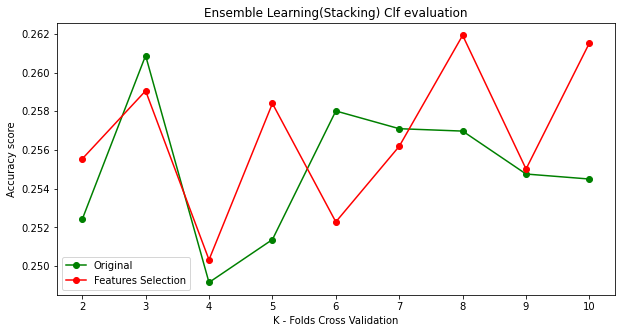

Stacking score:  [0.25240948163584265, 0.26087628834505666, 0.24915313694198366, 0.2513690960912053, 0.25801376808053167, 0.2570978723849193, 0.25697395290232883, 0.25475575786916665, 0.2544966862233812]
Stacking score with features selection:  [0.25553529564990884, 0.25905332079588383, 0.2503246726810839, 0.25840153365906626, 0.25228164907479805, 0.25618760236230576, 0.2619210549183177, 0.25501612377248994, 0.2615309919600174]


In [255]:
cv_list= list(range(2,11))
scoreList = []
scoreList2 = [] # features selection
for i in cv_list:
    score = Stack_train(meta_features_train, train_labels["genre"], cv=i)
    score2 = Stack_train(meta_features_train_select, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "Features Selection")
plt.title("Ensemble Learning(Stacking) Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("Stacking score: ", scoreList)
print("Stacking score with features selection: ", scoreList2)

## 3. Dealing with Audio features
We try to compare each model based on different K-folds CV and weither normalized or not

In [74]:
# split and retrieve Audio features
audio_features_train = train_features.drop(["trackID", "title", "tags", "loudness", "tempo", "time_signature", "key", "mode", "duration"], axis = 1)
audio_features_validate = validate_features.drop(["trackID", "title", "tags", "loudness", "tempo", "time_signature", "key", "mode", "duration"], axis = 1)

In [80]:
# Normalization
c = audio_features_train.columns
nor = preprocessing.normalize(audio_features_train)
audio_features_train_nor = pd.DataFrame(nor, columns=c)
c_v = audio_features_validate.columns
nor_v = preprocessing.normalize(audio_features_validate)
audio_features_validate_nor = pd.DataFrame(nor_v, columns=c_v)

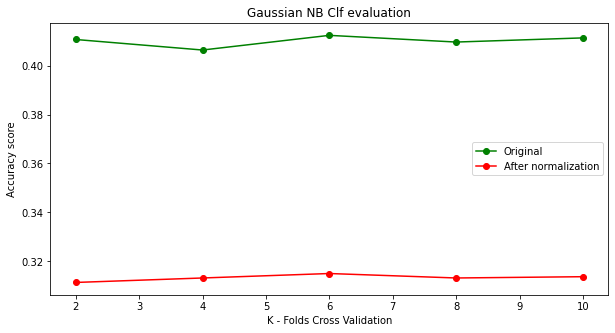

GNB score:  [0.41065381609794216, 0.4063540852440507, 0.4123462747589263, 0.4096117917970108, 0.4113084324750109]
GNB score with normalization:  [0.3114092211513415, 0.31323205716953273, 0.31505489314568674, 0.3132333213851234, 0.3137547194154715]


In [256]:
# Gaussian NB 
cv_list= [2,4,6,8,10]
scoreList = []
scoreList2 = [] # normalization
for i in cv_list:
    score = GNB_train(audio_features_train, train_labels["genre"], cv=i)
    score2 = GNB_train(audio_features_train_nor, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "After normalization")
plt.title("Gaussian NB Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("GNB score: ", scoreList)
print("GNB score with normalization: ", scoreList2)

In [83]:
# bagging to reduce bias
def Bagging_train(X,y,cv=0):
    bag = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators=10, random_state=0)
    if cv != 0:
        score = model_selection.cross_val_score(bag, X, y, cv=cv, scoring="accuracy")
        return score.mean()
    else:
        bag.fit(X,y)
        return bag


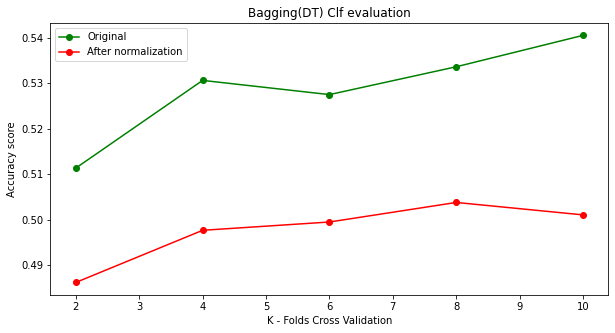

Bagging score:  [0.5113310758009899, 0.530607032742748, 0.5274824081313525, 0.5336039331334723, 0.5405061657974792]
Bagging score with normalization:  [0.48619432143787444, 0.4976554357738405, 0.49947977749543915, 0.5037753627911019, 0.5010437038244242]


In [257]:
cv_list= [2,4,6,8,10]
scoreList = []
scoreList2 = [] # normalization
for i in cv_list:
    score = Bagging_train(audio_features_train, train_labels["genre"], cv=i)
    score2 = Bagging_train(audio_features_train_nor, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "After normalization")
plt.title("Bagging(DT) Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("Bagging score: ", scoreList)
print("Bagging score with normalization: ", scoreList2)

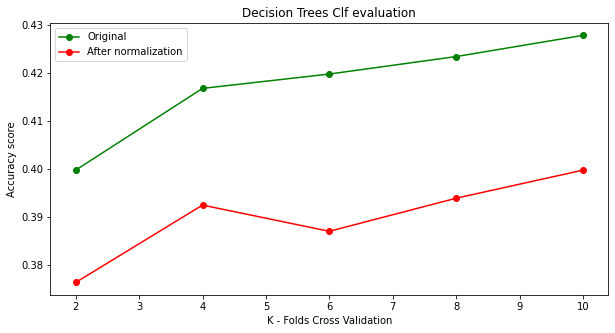

DT score:  [0.3997134670487106, 0.41677516230241446, 0.4197706948788116, 0.4234229720629128, 0.427847776781834]
DT score with normalization:  [0.3762698619432144, 0.39241731533350704, 0.38694618191295277, 0.39385020203336807, 0.39971394909821817]


In [258]:
# Decision Trees
cv_list= [2,4,6,8,10]
scoreList = []
scoreList2 = [] # normalization
for i in cv_list:
    score = DT_train(audio_features_train, train_labels["genre"], cv=i)
    score2 = DT_train(audio_features_train_nor, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "After normalization")
plt.title("Decision Trees Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("DT score: ", scoreList)
print("DT score with normalization: ", scoreList2)

In [20]:
# Neural Network - MLP

mlp = MLPClassifier(learning_rate_init=0.0005)

mlp.fit(meta_features_train, train_labels["genre"])

y_pred = mlp.predict(meta_features_validate)
mlp.score(meta_features_validate, validate_labels["genre"])


0.30444444444444446

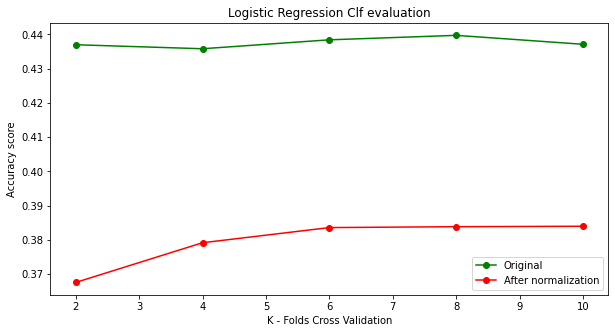

LR score:  [0.4369627507163324, 0.4357910749956575, 0.4383966966379984, 0.43970159345672577, 0.4370968125271621]
LR score with normalization:  [0.36754363115394634, 0.3791362688900469, 0.383564430218921, 0.38382578966805697, 0.38395738265971313]


In [259]:
# Logistic Regression
cv_list= [2,4,6,8,10]
scoreList = []
scoreList2 = [] # normalization
for i in cv_list:
    score = LR_train(audio_features_train, train_labels["genre"], cv=i)
    score2 = LR_train(audio_features_train_nor, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "After normalization")
plt.title("Logistic Regression Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("LR score: ", scoreList)
print("LR score with normalization: ", scoreList2)

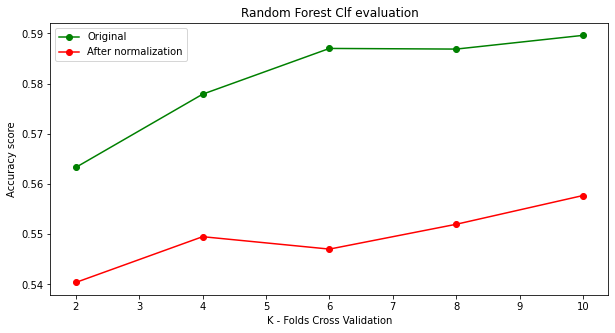

RF score:  [0.5632977337848397, 0.5778858889178392, 0.5870039052319521, 0.5868743482794578, 0.5896098163841809]
RF score with normalization:  [0.5403750976816879, 0.5494927371026577, 0.5470189519807142, 0.5519694180135558, 0.5576992679813124]


In [260]:
# Random Forest
cv_list= [2,4,6,8,10]
scoreList = []
scoreList2 = [] # normalization
for i in cv_list:
    score = RF_train(audio_features_train, train_labels["genre"], cv=i)
    score2 = RF_train(audio_features_train_nor, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "After normalization")
plt.title("Random Forest Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("RF score: ", scoreList)
print("RF score with normalization: ", scoreList2)

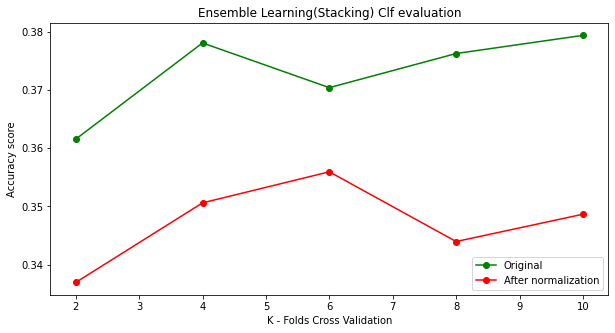

Stacking score:  [0.3615524876269862, 0.37809290591888134, 0.3704104362131873, 0.37627642183698295, 0.37939771430899605]
Stacking score with normalization:  [0.3369367022662152, 0.3506112124370332, 0.3559498794631222, 0.3439692768074383, 0.3486583618535419]


In [261]:
# Stacking method
cv_list= [2,4,6,8,10]
scoreList = []
scoreList2 = [] # normalization
for i in cv_list:
    score = Stack_train(audio_features_train, train_labels["genre"], cv=i)
    score2 = Stack_train(audio_features_train_nor, train_labels["genre"], cv=i)
    scoreList.append(score)
    scoreList2.append(score2)
plt.figure(figsize=(10,5))
plt.plot(cv_list, scoreList, "o-", color = "g", label = "Original")
plt.plot(cv_list, scoreList2, "o-", color = "r", label = "After normalization")
plt.title("Ensemble Learning(Stacking) Clf evaluation")
plt.legend(loc = "best")
plt.xlabel("K - Folds Cross Validation")
plt.ylabel("Accuracy score")
plt.show()
print("Stacking score: ", scoreList)
print("Stacking score with normalization: ", scoreList2)

## 4. Test our method
Based on above comparison, we found out that using NB classifier to predict tags features (with entire tag words), Random forest classifier to predict metadata (without features selection) and audio data could provide better performance.
In testing, we will combine these methods using majority voting to do our testing on validation dataset

In [184]:
def predict(clf, validate):
    return clf.predict(validate)
def predict_proba(clf, validate):
    return clf.predict_proba(validate)

In [185]:
# tags features (using NB classifier)
NB = MultinomialNB()
NB.fit(tags_features_train_all, train_labels["genre"])
y_tags = predict(NB, tags_features_validate_all)
y_tags_prob = predict_proba(NB, tags_features_validate_all)
# metadata features (using Random Forest without features selection)
RF1 = RandomForestClassifier()
RF1.fit(meta_features_train, train_labels["genre"])
y_meta = predict(RF1, meta_features_validate)
y_meta_prob = predict_proba(RF1, meta_features_validate)
# audio features (using Random Forest without normalization)
RF2 = RandomForestClassifier()
RF2.fit(audio_features_train, train_labels["genre"])
y_audio = predict(RF2, audio_features_validate)
y_audio_prob = predict_proba(RF2, audio_features_validate)

print("tags prediction score: ", accuracy_score(validate_labels["genre"], y_tags))
print("metadata prediction score: ", accuracy_score(validate_labels["genre"], y_meta))
print("audio prediction score: ", accuracy_score(validate_labels["genre"], y_audio))

y_pred = MajorityVote(y_tags, y_meta, y_audio)
print("Majority Voting: ",accuracy_score(validate_labels["genre"], y_pred))

y_predprob = MajorityVoteProb(y_tags_prob, y_meta_prob, y_audio_prob)
print("Majority Voting using combine probability: ",accuracy_score(validate_labels["genre"], y_predprob))

tags prediction score:  0.5866666666666667
metadata prediction score:  0.26
audio prediction score:  0.44666666666666666
Majority Voting:  0.26
Majority Voting using combine probability:  0.6311111111111111


In [186]:
def evaluate(pred):
    return confusion_matrix(validate_labels["genre"], pred)

Text(0, 0.5, 'True')

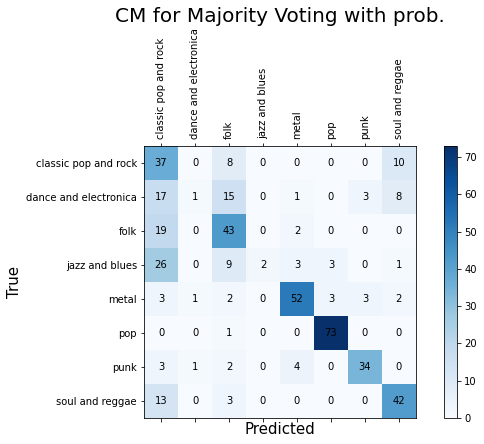

In [264]:
# plot confusion matrix
cm = evaluate(y_predprob)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap="Blues")
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center')
ax.set_xticklabels(['']+genre_class, rotation = 90)
ax.set_yticklabels(['']+genre_class)
plt.title('CM for Majority Voting with prob.', fontsize = 20)
fig.colorbar(cax)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('True', fontsize = 15)
print(accuracy_score())


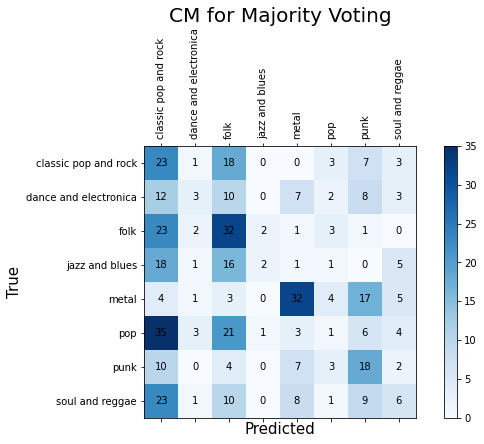

In [266]:
fig = plt.figure(figsize=(10,5))
cm2 = evaluate(y_pred)
ax2 = fig.add_subplot(111)
cax2 = ax2.matshow(cm2, cmap="Blues")
for (i, j), z in np.ndenumerate(cm2):
    ax2.text(j, i, '{:d}'.format(z), ha='center', va='center')
ax2.set_xticklabels(['']+genre_class, rotation = 90)
ax2.set_yticklabels(['']+genre_class)
plt.title('CM for Majority Voting', fontsize = 20)
fig.colorbar(cax2)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('True', fontsize = 15)
plt.show()

In [155]:
# Majority Voting
def most_frequent(List): 
    return max(set(List), key = List.count)
def MajorityVote(p1, p2, p3):
    predict = []
    for i in range(len(p1)):
        List = []
        List.append(p1[i])
        List.append(p2[i])
        List.append(p2[i])
        mv = most_frequent(List)
        predict.append(mv)
    return predict

In [170]:
# Majority Voting using combination of probability
def MajorityVoteProb(p1,p2,p3):
    predict = []
    for i in range(len(p1)):
        List = []
        for j in range(len(p1[i])):
            prob = p1[i][j]+p2[i][j]+p3[i][j]
            List.append(prob)
        predict.append(List.index(max(List)))
    return predict

## 5. Final Result on test dataset

In [191]:
tags_features_test = oneHotTransfer(test_features["tags"], tagsFrequency_all)
meta_features_test = test_features[["loudness", "tempo", "time_signature", "key", "mode", "duration"]]
audio_features_test = test_features.drop(["trackID", "title", "tags", "loudness", "tempo", 
                                           "time_signature", "key", "mode", "duration"], axis = 1)

In [262]:
# tags features (using NB classifier)
NB = MultinomialNB()
NB.fit(tags_features_train_all, train_labels["genre"])
y_test_tags= predict_proba(NB, tags_features_test)
# metadata features (using Random Forest without features selection)
RF1 = RandomForestClassifier()
RF1.fit(meta_features_train, train_labels["genre"])
y_test_meta= predict_proba(RF1, meta_features_test)
# audio features (using Random Forest without normalization)
RF2 = RandomForestClassifier()
RF2.fit(audio_features_train, train_labels["genre"])
y_test_audio= predict_proba(RF2, audio_features_test)

y_test = MajorityVoteProb(y_test_tags, y_test_meta, y_test_audio)
print(y_test)

[7, 7, 0, 2, 7, 2, 4, 5, 2, 0, 0, 2, 0, 0, 2, 7, 0, 2, 4, 0, 7, 0, 5, 2, 0, 0, 7, 7, 2, 7, 2, 7, 2, 4, 7, 5, 7, 0, 0, 0, 0, 0, 0, 7, 0, 2, 5, 0, 0, 7, 0, 5, 7, 2, 7, 0, 7, 0, 5, 5, 0, 7, 0, 4, 5, 7, 7, 2, 4, 0, 2, 4, 0, 5, 0, 0, 2, 7, 5, 7, 2, 6, 5, 0, 7, 0, 2, 7, 2, 0, 7, 7, 0, 2, 2, 5, 7, 5, 0, 4, 0, 1, 4, 7, 5, 2, 0, 7, 5, 2, 0, 7, 0, 7, 0, 2, 0, 5, 5, 0, 0, 0, 0, 4, 0, 0, 7, 7, 2, 0, 5, 6, 2, 7, 4, 7, 2, 0, 4, 0, 0, 7, 4, 7, 5, 5, 2, 0, 2, 2, 0, 0, 7, 7, 7, 5, 6, 7, 7, 7, 5, 0, 0, 5, 0, 5, 2, 0, 2, 7, 7, 0, 0, 7, 2, 2, 7, 5, 7, 2, 7, 0, 4, 2, 0, 2, 5, 2, 0, 4, 0, 7, 5, 2, 2, 5, 0, 0, 0, 7, 7, 5, 7, 0, 5, 2, 4, 4, 4, 7, 4, 7, 7, 0, 0, 0, 0, 0, 2, 5, 7, 0, 4, 5, 6, 5, 0, 5, 0, 0, 0, 0, 2, 0, 0, 5, 0, 4, 7, 7, 2, 5, 0, 2, 7, 2, 4, 2, 0, 2, 2, 4, 0, 0, 0, 0, 7, 4, 7, 0, 0, 0, 0, 0, 4, 7, 7, 5, 7, 7, 7, 2, 5, 2, 0, 6, 5, 0, 2, 7, 0, 2, 0, 7, 2, 0, 7, 0, 0, 5, 5, 0, 7, 6, 2, 0, 2, 7, 0, 0, 2, 0, 0, 6, 0, 2, 5, 0, 0, 2, 7, 0, 2, 7, 2, 0, 7, 4, 5, 6, 7, 7, 5, 7, 6, 0, 0, 7, 5, 6, 6, 7, 7, 

In [202]:
def transferClass(y):
    pred=[]
    for i in range(len(y)):
        pred.append(genre_class[y[i]])
    return pred

In [263]:
y_hat = transferClass(y_test)
dataframe = pd.concat([test_features["trackID"], pd.DataFrame(y_hat, columns=["genre"])],axis=1)
dataframe.to_csv("MusicGenrePrediction.csv", index=False, header = True)